# Классификация текстов

Построим модель классификации текстов, для этого будем использовать набор данных **«The 20 Newsgroups»** — это коллекция примерно из 20000 новостных документов, разделенная (приблизительно) равномерно между 20 различными категориями.

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 200

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC as svc
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from lightgbm import LGBMClassifier
import random
#log_loss
from sklearn.metrics import log_loss
#hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hpsklearn import HyperoptEstimator, any_classifier
from hyperopt.fmin import fmin
from hyperopt import space_eval

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [ ]:
import nltk

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrcho\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrcho\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Загрузка данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups

Возвращаемый набор данных — это `scikit-learn совокупность`: одномерный контейнер с полями, которые могут интерпретироваться как ключи в словаре python (dict keys), проще говоря — как признаки объекта (object attributes). Например, `target_names` содержит список названий запрошенных категорий, разбитых (более или менее) по тематике:

![image.png](attachment:image.png)

Будем использовать для моделирования 4 категории:

    'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'

In [ ]:
categories = ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

train = fetch_20newsgroups(subset='train',
                           categories=categories,
                           shuffle=True, random_state=42)

test = fetch_20newsgroups(subset='test',
                          categories=categories,
                          shuffle=True, random_state=42)

In [ ]:
train.target_names

['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

Сами файлы загружаются в память как атрибут data:

In [ ]:
print(len(train.data))
print(len(test.data))

2373
1579


Посмотрим на пример самих данных:

In [ ]:
print(train.data[10])

From: turpin@cs.utexas.edu (Russell Turpin)
Subject: Re: Great Post! (was Re: Candida (yeast) Bloom...) (VERY LONG)
Summary: How virtually?
Organization: CS Dept, University of Texas at Austin
Lines: 30
NNTP-Posting-Host: im4u.cs.utexas.edu

-*-----
In article <noringC5wzM4.41n@netcom.com> noring@netcom.com (Jon Noring) writes:
>> ... if you can't observe or culture the yeast "bloom" in the
>> gut or sinus, then there's no way to diagnose or even recognize
>> the disease.  And I know they realize that it is virtually
>> impossible to test for candida overbloom in any part of the body 
>> that cannot be easily observed since candida is everywhere in 
>> the body.

In article <C5y5nM.Axv@toads.pgh.pa.us> geb@cs.pitt.edu (Gordon Banks) writes:
> You've just discovered one of the requirements for a good quack theory.
> Find something that no one can *disprove* and then write a book saying
> it is the cause of whatever.  Since no one can disprove it, you can
> rake in the bucks for quite so

Индекс категории каждой выборки хранится в атрибуте `target`:

In [ ]:
print(train.target[10])
print(categories[train.target[10]])

2
sci.med


Text(0.5, 1.0, 'Распределение меток в обучающей выборке')

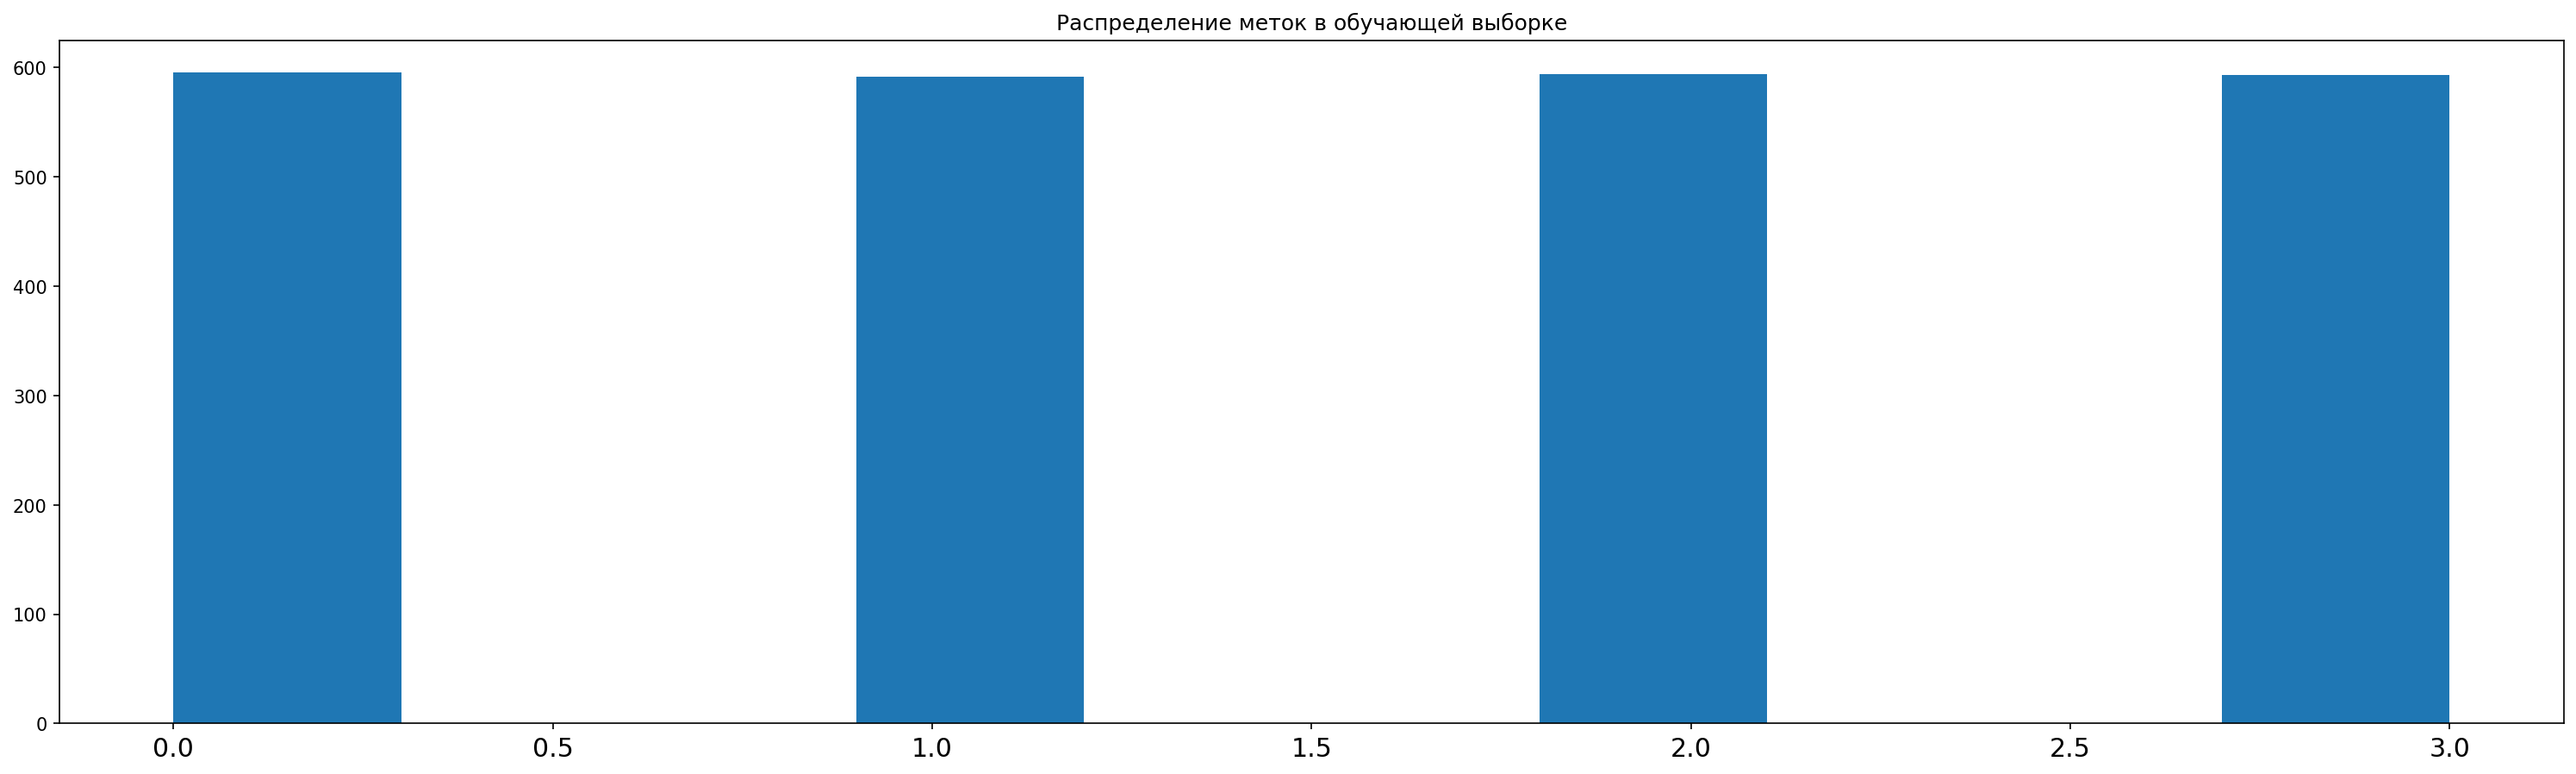

In [ ]:
plt.hist(train['target'])
plt.title('Распределение меток в обучающей выборке')

Text(0.5, 1.0, 'Распределение меток в тестовой выборке')

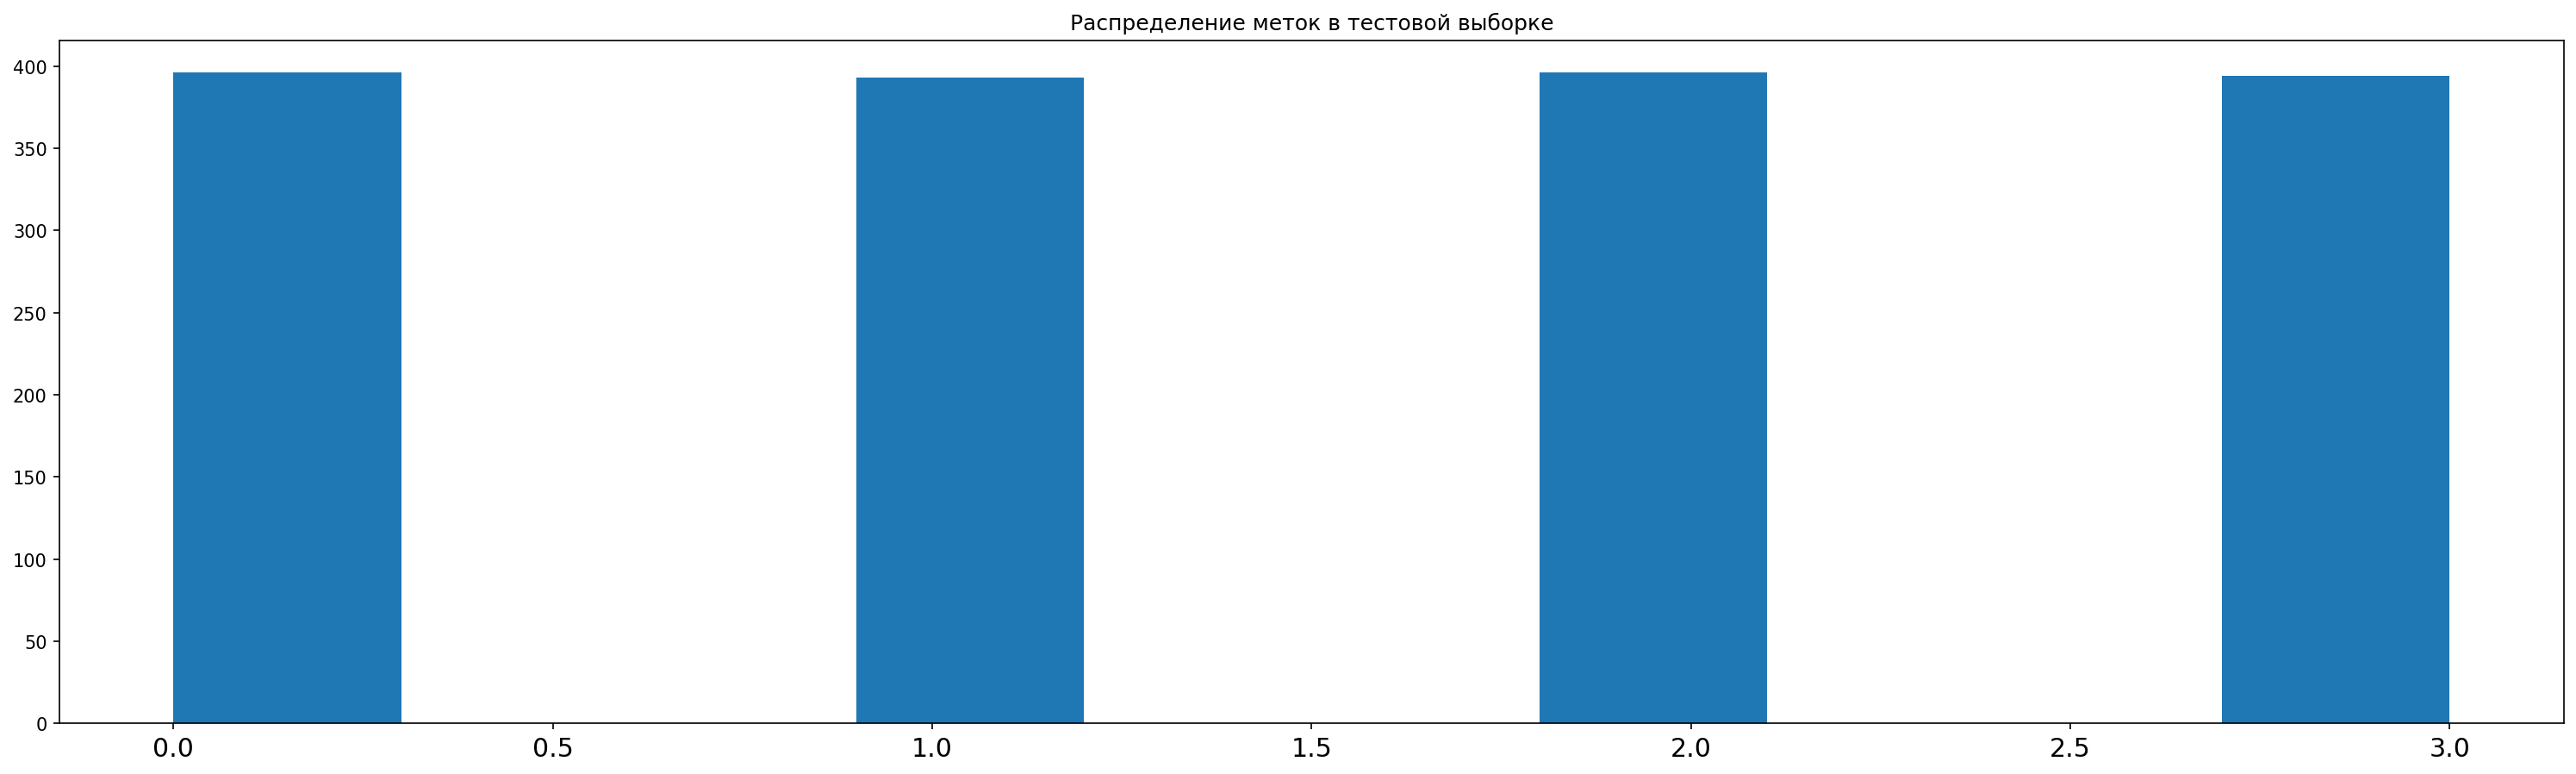

In [ ]:
plt.hist(test['target'])
plt.title('Распределение меток в тестовой выборке')

### Предобработка данных

Проверим на наличие не пустых текстов и посмотрим на распределение в зависимости от длины текста:

In [ ]:
len_symb = [len(i) for i in train.data]
print(min(len_symb), max(len_symb))

166 72637


(array([2., 4., 6., ..., 0., 0., 1.]),
 array([  166.        ,   196.53982301,   227.07964602, ...,
        72575.92035398, 72606.46017699, 72637.        ]),
 <BarContainer object of 2373 artists>)

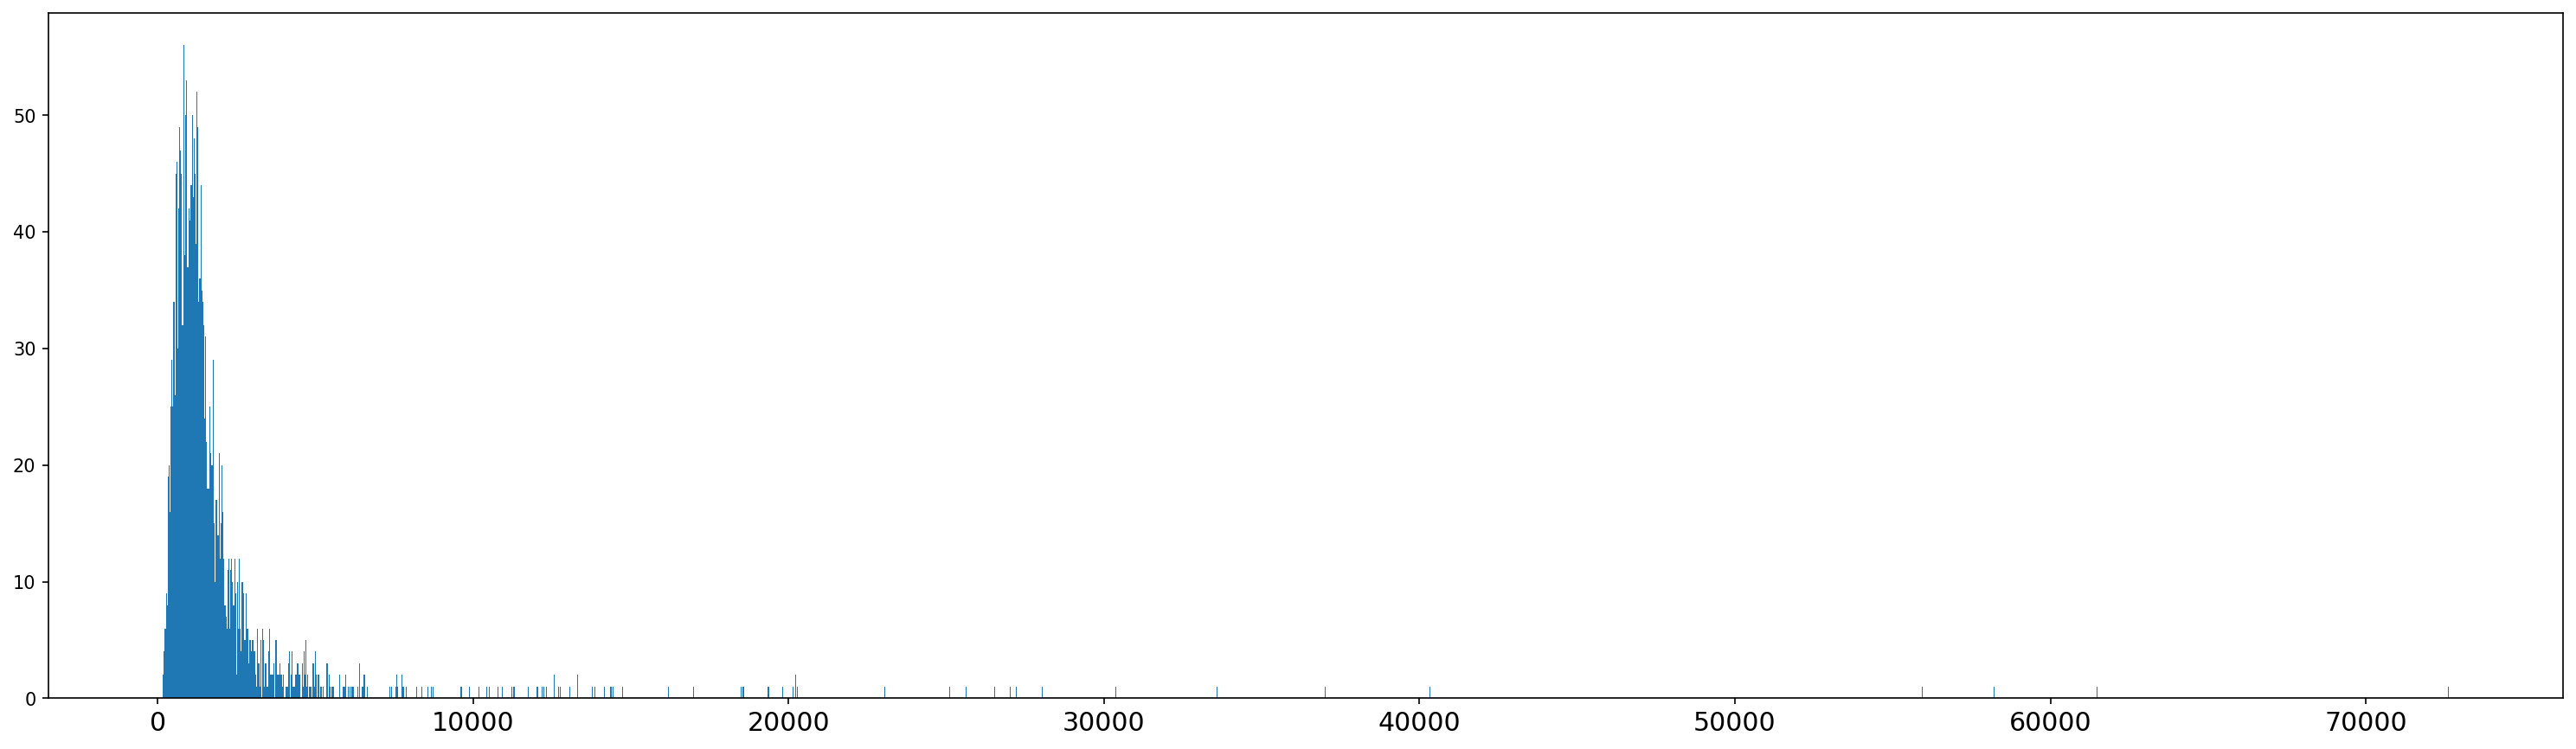

In [ ]:
n_bins = len(len_symb)
plt.hist(len_symb, bins=n_bins)

Создадим общую функцию для предобработки:

Используем Regex Expressions из библиотеки Python re для выполнения различных задач предварительной обработки. Мы начинаем с удаления всех символов, отличных от слов, таких как специальные символы, числа и т. Д.

Далее мы удаляем все одиночные символы. Например, когда мы удаляем знак препинания из «David's» и заменяем его пробелом, мы получаем «David» и один символ «s», который не имеет значения. Чтобы удалить такие одиночные символы, мы используем регулярное выражение `\ s + [a-zA-Z] \ s +`, которое заменяет все одиночные символы, имеющие пробелы с обеих сторон, на единичный пробел.

Затем мы используем регулярное выражение `\ ^ [a-zA-Z] \ s +` для замены одного символа из начала документа одним пробелом. Замена отдельных символов одним пробелом может привести к появлению нескольких пробелов, что не идеально.

Мы снова используем регулярное выражение `\ s +`, чтобы заменить одно или несколько пробелов одним пробелом. Следующим шагом является преобразование данных в нижний регистр, чтобы слова, которые на самом деле являются одинаковыми, но имеют разные регистры, можно было обрабатывать одинаково.

Следущий шаг предварительной обработки - `лемматизация`. При лемматизации мы сводим слово к словарной корневой форме. Например, «кошка» превращаются в «кот». Лемматизация выполняется, чтобы избежать создания функций, которые семантически похожи, но синтаксически отличаются. Например, нам не нужны две разные функции с именами «коты» и «кот», которые семантически похожи, поэтому мы выполняем лемматизацию.

Заключительный шаг - удаление стоп-слов, которые, поскольку стоп-слова могут не содержать никакой полезной информации. Чтобы удалить стоп-слова, мы подгружаем объект стоп-слов из библиотеки `nltk.corpus`

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
en_stops = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrcho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# пример лемматизации
stemmer.lemmatize('cats')

'cat'

In [ ]:
# стоп-слова
en_stops

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
def clean_txt(text):
    # удаляем спец символы
    document = re.sub(r'\W', ' ', text)

    # удаляем отдельно стоящие буквы
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # удаляем отдельно стоящие буквы в начале текста
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # убираем двойные пробеоы
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # переводим в нижний регистр
    document = document.lower()

    # лемматизируем
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]

    # удаляем стоп-слова
    document_fin = []
    for word in document:
        if word not in en_stops:
            document_fin.append(word)

    fin_text = ' '.join(document_fin)
    return fin_text

Посмотрим, что возращает функция:

In [ ]:
clean_txt(train.data[10])

'turpin c utexas edu russell turpin subject great post wa candida yeast bloom long summary virtually organization c dept university texas austin line 30 nntp posting host im4u c utexas edu article noringc5wzm4 41n netcom com noring netcom com jon noring writes observe culture yeast bloom gut sinus way diagnose even recognize disease know realize virtually impossible test candida overbloom part body cannot easily observed since candida everywhere body article c5y5nm axv toad pgh pa u geb c pitt edu gordon bank writes discovered one requirement good quack theory find something one disprove write book saying cause whatever since one disprove rake buck quite time hope gordon bank mean imply notion hard see candida infection causing various problem investigated many researcher made breakthrough figuring investigate thing previously thought virtually impossible test indeed would surprised candida overbloom phenomenon would think candida would produce signature byproduct whose measure would s

Создадим список из документов, преобразованных функцией `clean_txt`

In [ ]:
documents = [clean_txt(i) for i in train.data]

Создадим **мешок слов**:

Используем класс `CountVectorizer` из библиотеки `sklearn.feature_extraction.text`, со следующим параметрами:

- `max_features`, для которого установлено значение 1500. Это связано с тем, что при преобразовании слов в числа с использованием подхода «мешок слов» все уникальные слова во всех документах преобразуются в функции. Все документы могут содержать десятки тысяч уникальных слов. Но слова, которые встречаются очень редко, обычно не подходят для классификации документов. Поэтому мы устанавливаем параметр *max_features* на 1500, что означает, что мы хотим использовать 1500 наиболее часто встречающихся слов в качестве функций для обучения нашего классификатора.

- `min_df`, для которого установлено значение 0.05. Это соответствует проценту минимального количества документов, которые должны содержать это слово. Поэтому мы включаем только те слова, которые встречаются как минимум в 5% документах.
- `max_df` значение установлено на 0,7; в котором дробь соответствует проценту. Здесь 0,7 означает, что мы должны включать только те слова, которые встречаются максимум в 70% всех документов. Слова, которые встречаются почти в каждом документе, обычно не подходят для классификации, потому что они не предоставляют никакой уникальной информации о документе.

Функция `fit_transform` класса `CountVectorizer` преобразует текстовые документы в соответствующие числовые функции.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=0.05, max_df=0.7)
X = vectorizer.fit_transform(documents).toarray()

In [ ]:
X

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Определим **TF-IDF**

Подход «мешок слов» отлично подходит для преобразования текста в числа. Однако у него есть один недостаток. Он присваивает оценку слову на основе его появления в конкретном документе. При этом не учитывается тот факт, что это слово может также часто встречаться в других документах. `TFIDF` решает эту проблему, умножая частоту термина слова на обратную частоту документа. TF означает "Term Frequency", а IDF - "Inverse Document Frequency":

`TF = (Количество вхождений слова) / (Всего слов в документе)`

`IDF = Log((Общее количество документов) / (Количество документов, содержащих слово))`

Значение TFIDF для слова в конкретном документе выше, если TF этого слова выше в этом конкретном документе, но ниже во всех других документах.

Преобразуем значения, полученные с помощью модели мешка слов, в значения TFIDF:

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [ ]:
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.19809688,
        0.        ],
       [0.        , 0.        , 0.24637674, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.10428913, 0.15172363,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.10929184, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Можно напрямую преобразовать текстовые документы в значения функций TFIDF (без предварительного преобразования документов в функции набора слов), используя следующий скрипт:

`from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=0.05, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()`

### Построение модели

In [ ]:
from sklearn.model_selection import train_test_split

y = train.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[112   4   1   0]
 [  2  97   9   6]
 [  2  19 101   3]
 [  1  19   3  96]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       117
           1       0.70      0.85      0.77       114
           2       0.89      0.81      0.85       125
           3       0.91      0.81      0.86       119

    accuracy                           0.85       475
   macro avg       0.86      0.86      0.86       475
weighted avg       0.87      0.85      0.86       475

0.8547368421052631


In [ ]:
%%time
rf = RandomForestClassifier(n_estimators=1, random_state=42, verbose=0, n_jobs=3)
kf = KFold(n_splits=5, random_state=42, shuffle=True)
parameters = {'n_estimators': range(900, 1000, 50),
              'max_depth': [7,9,10,12],
              'min_samples_split':[2,4,6],
              'min_samples_leaf':[6,8,10,12] }
clf = GridSearchCV(rf, parameters, cv=kf, scoring='f1_micro')
clf.fit(X_train, y_train)

Wall time: 17min 8s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=1, n_jobs=3,
                                              random_state=42),
             param_grid={'max_depth': [7, 9, 10, 12],
                         'min_samples_leaf': [6, 8, 10, 12],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': range(900, 1000, 50)},
             scoring='f1_micro')

In [ ]:
clf.best_params_

{'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 900}

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=12, min_samples_leaf=8, min_samples_split=2)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=8, random_state=42)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.8063157894736842


In [ ]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=7, subsample=0.5, colsample_bytree=1.0, reg_alpha=0, reg_lambda=1,
                   min_child_weight=3, gamma=2, tree_method = "gpu_hist", predictor = "gpu_predictor")
xgb.fit(X_train, y_train)
print("Точность для обучающей выборки:", xgb.score(X_train, y_train))
print("Точность для тестовой выборки:", xgb.score(X_test, y_test))

[21:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Точность для обучающей выборки: 0.9494204425711275
Точность для тестовой выборки: 0.8273684210526315


In [ ]:
cat = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1)

cat.fit(X_train, y_train)
print("Точность для обучающей выборки:", cat.score(X_train, y_train))
print("Точность для тестовой выборки:", cat.score(X_test, y_test))

0:	learn: 1.0909386	total: 157ms	remaining: 157ms
1:	learn: 0.9534524	total: 165ms	remaining: 0us
Точность для обучающей выборки: 0.553213909378293
Точность для тестовой выборки: 0.5726315789473684


Из выходных данных видно, что наша модель достигла точности на тестовых данных 85,5%, что очень хорошо, учитывая тот факт, что мы случайным образом выбрали все параметры для CountVectorizer, а также для нашего алгоритма случайного леса.

## [Задание]

Основная задача улучшить модель. Отметим, что оценку мы производили только на валидационной выборке и не производили на тестовой выборке.

Гипотезы для улучшения:
- Вытащить из описания доп переменные: тема, отправитель, получатель и тп
![image.png](attachment:image.png)
- Произвести более аккуратную предобработку текста
- Выбрать оптимальный алгоритм и подобрать его параметры
- Использовать NER